# Insurance Claims Fraud EDA

Exploratory Data Analysis for `insurance_claims.csv`

## Plan of Action

1. Remove irrelevant columns that should have no bearing on fraudulent claims (e.g. postcodes, car model, policy numbers, `_c39`).
2. Identify and handle missing data.
3. Identify and process categorical variables, and create new categorical features where appropriate.
4. Explore and visualize features to see how fraud is allocated across them.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1. Removing Irrelevant Data

In [3]:
df = pd.read_csv('insurance_claims.csv')
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,17/10/2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,27/06/2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,06/09/2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,25/05/1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,06/06/2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [4]:
# Remove columns that are irrelevant to fraud detection
cols_to_drop = ['_c39', 'policy_number', 'insured_zip', 'incident_location', 'auto_model', 'policy_bind_date', "total_claim_amount"]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
#Total claim amount removed,as it is simply the sum of vehicle, property and injury claim :)

## 2. Handling Missing Data

In [5]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# For categorical columns with missing data, fill with 'Missing' label
for col in ['collision_type', 'property_damage', 'police_report_available']:
    df[col] = df[col].fillna('Missing')

# Confirm no '?' remains
assert not (df == '?').any().any(), "There are still question marks in the data"

## 3. Feature Engineering and Categorical Variables

In [6]:
# Convert incident_date to Year-Month
df['incident_date'] = pd.to_datetime(df['incident_date'], format='%d/%m/%Y', errors='coerce')
df['incident_date'] = df['incident_date'].dt.strftime('%Y-%m')

In [7]:
# Convert incident_hour_of_the_day into time-of-day periods
def hour_to_period(hour):
    if pd.isnull(hour):
        return None
    hour = int(hour)
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour <= 23:
        return 'Evening'
    return None

df['incident_hour_of_the_day'] = df['incident_hour_of_the_day'].apply(hour_to_period)

In [8]:
# Convert months_as_customer to years (rounded)
df['years_as_customer'] = np.round(df['months_as_customer'] / 12)
df.drop('months_as_customer', axis=1, inplace=True)

In [9]:
# Review unique values and datatypes
summary = pd.DataFrame({
    'unique_values': df.nunique(),
    'dtype': df.dtypes
}).sort_values('unique_values')
print(summary)

                             unique_values    dtype
insured_sex                              2   object
fraud_reported                           2   object
police_report_available                  3   object
policy_state                             3   object
policy_csl                               3   object
policy_deductable                        3    int64
property_damage                          3   object
bodily_injuries                          3    int64
incident_date                            3   object
number_of_vehicles_involved              4    int64
incident_hour_of_the_day                 4   object
authorities_contacted                    4   object
collision_type                           4   object
incident_type                            4   object
incident_severity                        4   object
witnesses                                4    int64
insured_relationship                     6   object
incident_state                           7   object
incident_cit

### Categorize 'age' and 'years_as_customer' as bins

- **Age:** `Old` if >35, else `Young`
- **Years as customer:** `Long Term` if >15, else `Short Term`

In [10]:
# Age group binning
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age'] = df['age'].apply(lambda x: 'Old' if x > 35 else 'Young')

# Years as customer binning
df['years_as_customer'] = pd.to_numeric(df['years_as_customer'], errors='coerce')
df['years_as_customer'] = df['years_as_customer'].apply(lambda x: 'Long Term' if x > 15 else 'Short Term')

In [11]:
# Convert relevant categorical columns to numerical codes & store mappings
categorical_columns = [
    'authorities_contacted', 'incident_hour_of_the_day', 'incident_severity', 'incident_type', 'collision_type',
    'insured_relationship', 'incident_state', 'incident_city', 'insured_education_level',
    'witnesses', 'number_of_vehicles_involved', 'fraud_reported', 'insured_sex',
    'police_report_available', 'policy_state', 'policy_csl', 'policy_deductable',
    'bodily_injuries', 'property_damage', 'insured_occupation', 'auto_make', 'insured_hobbies', 'auto_year',
    'age', 'years_as_customer', 'incident_date'
]

category_mappings = {}
for col in categorical_columns:
    df[col] = df[col].astype('category')
    category_mappings[col] = dict(enumerate(df[col].cat.categories))
    df[col] = df[col].cat.codes  # Overwrite with numeric codes


## 4. Data Overview (after cleaning and encoding)

In [12]:
#Moving years as customer to the first position, for completeness

col = df.pop("years_as_customer")
df.insert(0, 'years_as_customer', col)

df.head()

,years_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported
0,0,0,2,1,1,1406.91,0,1,4,2,...,2,1,2,2,6510,13020,52080,10,9,1
1,0,0,1,1,2,1197.22,5000000,1,4,6,...,0,0,0,0,780,780,3510,8,12,1
2,1,1,2,0,2,1413.14,5000000,0,6,11,...,1,2,3,1,7700,3850,23100,4,12,0
3,0,0,0,1,2,1415.74,6000000,0,6,1,...,0,1,2,1,6340,6340,50720,3,19,1
4,0,0,0,2,1,1583.91,6000000,1,0,11,...,1,0,1,1,1300,650,4550,0,14,0


In [13]:
# View category mappings for interpretation
import pprint
pprint.pprint(category_mappings)

{'age': {0: 'Old', 1: 'Young'},
 'authorities_contacted': {0: 'Ambulance', 1: 'Fire', 2: 'Other', 3: 'Police'},
 'auto_make': {0: 'Accura',
               1: 'Audi',
               2: 'BMW',
               3: 'Chevrolet',
               4: 'Dodge',
               5: 'Ford',
               6: 'Honda',
               7: 'Jeep',
               8: 'Mercedes',
               9: 'Nissan',
               10: 'Saab',
               11: 'Suburu',
               12: 'Toyota',
               13: 'Volkswagen'},
 'auto_year': {0: 1995,
               1: 1996,
               2: 1997,
               3: 1998,
               4: 1999,
               5: 2000,
               6: 2001,
               7: 2002,
               8: 2003,
               9: 2004,
               10: 2005,
               11: 2006,
               12: 2007,
               13: 2008,
               14: 2009,
               15: 2010,
               16: 2011,
               17: 2012,
               18: 2013,
               19: 2014,
     

In [14]:

cat_features = [
    'incident_severity', 'incident_type', 'collision_type', 'insured_sex',
    'policy_state', 'auto_make'
]

# Find rows where any categorical column has a -1
mask = df[cat_features].eq(-1).any(axis=1)
rows_with_minus1 = df[mask]

print(f"Number of rows with -1 in categorical columns: {rows_with_minus1.shape[0]}")
display(rows_with_minus1)

Number of rows with -1 in categorical columns: 0


,years_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported


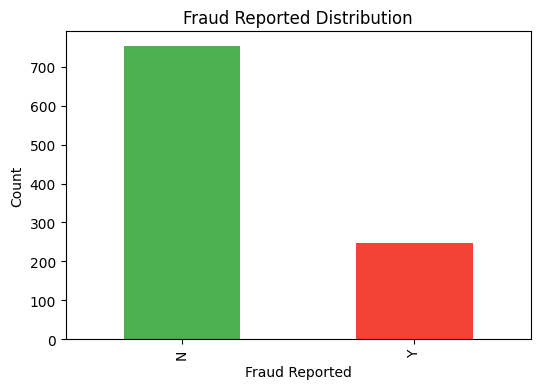

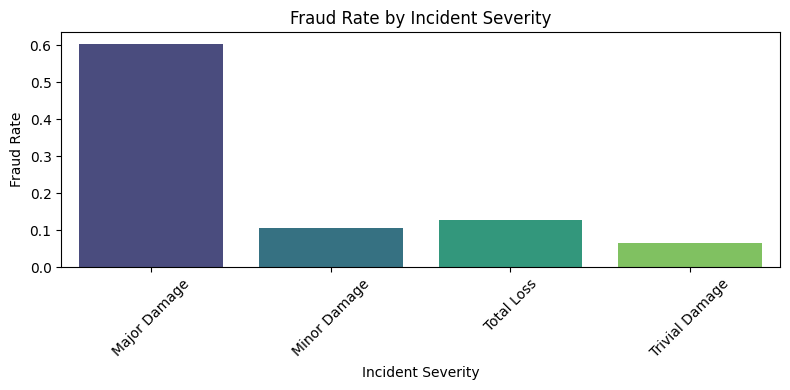

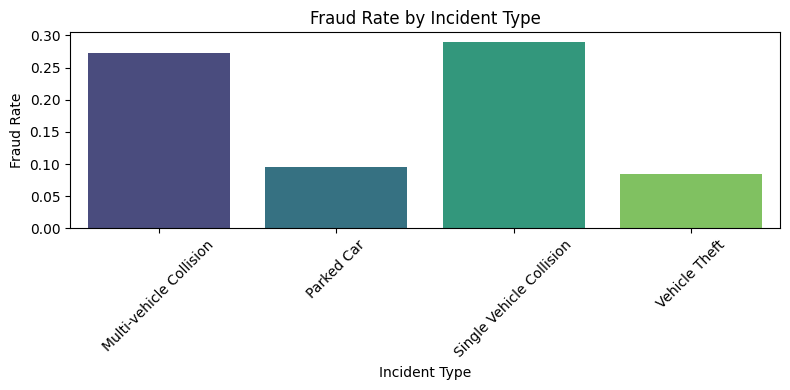

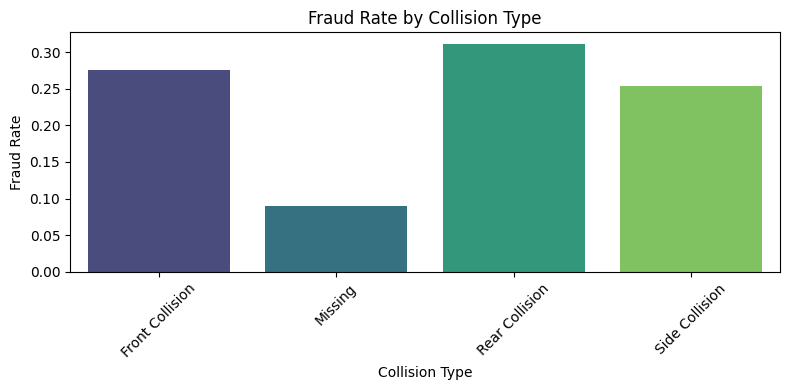

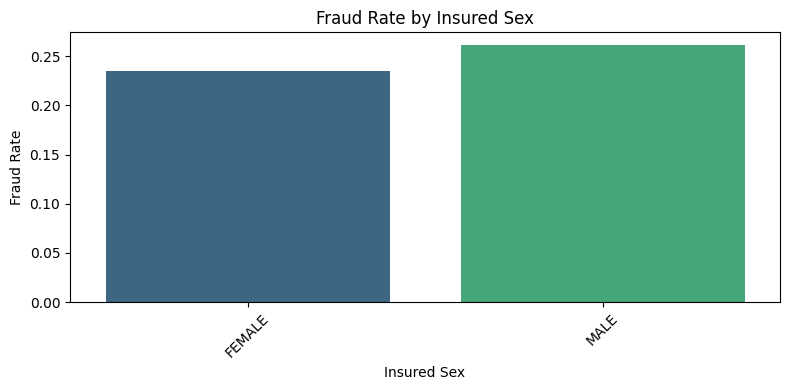

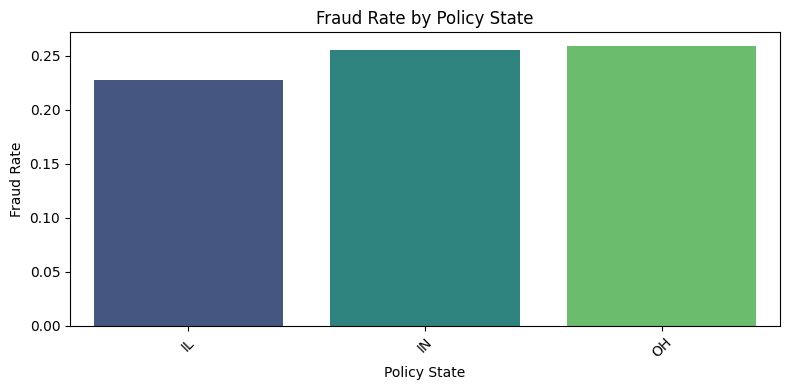

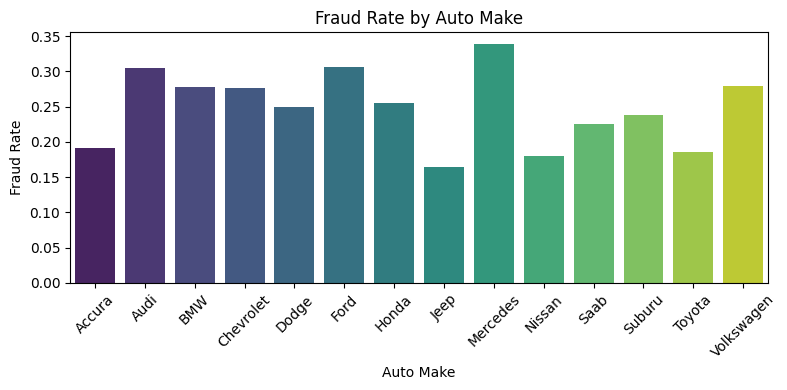

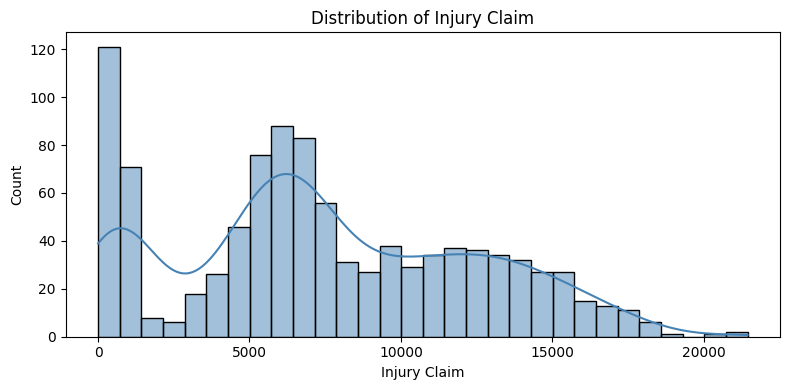

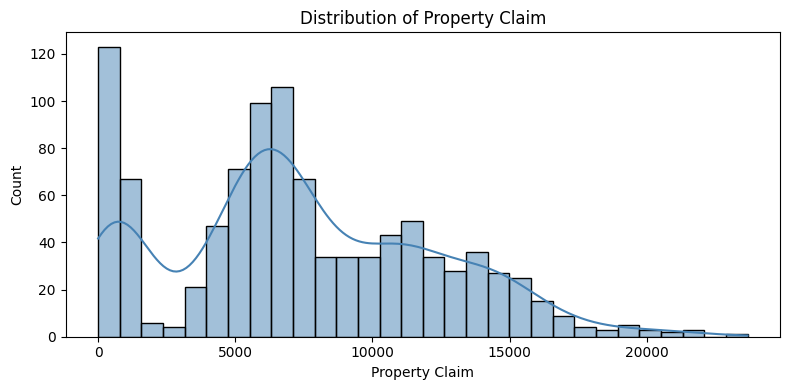

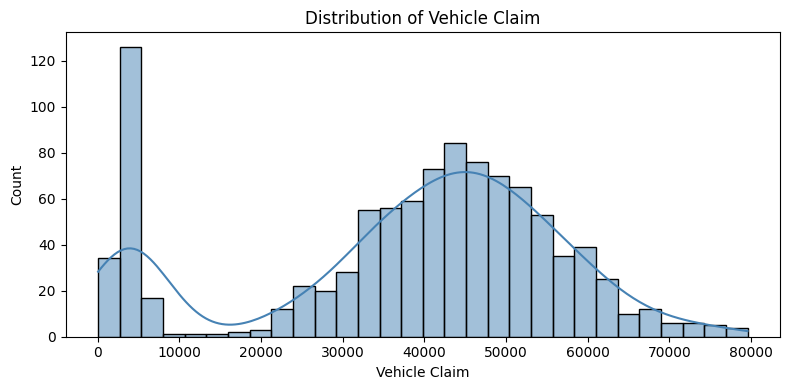

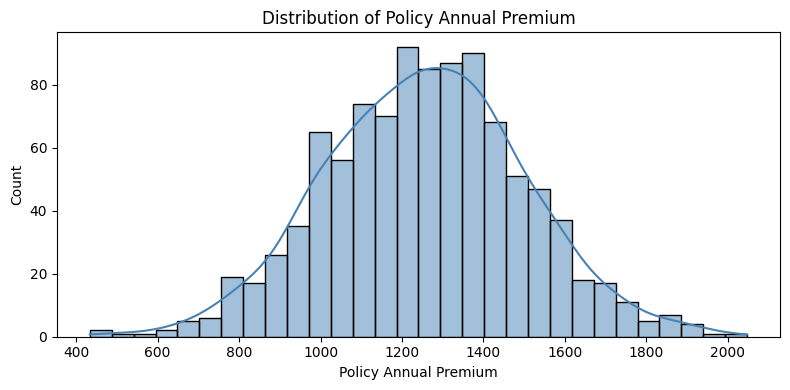

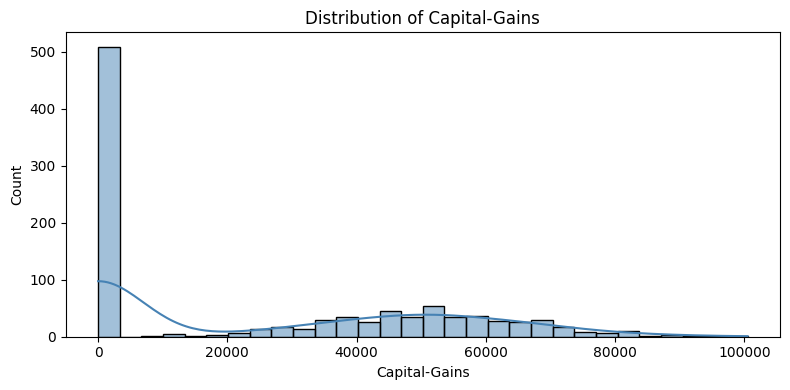

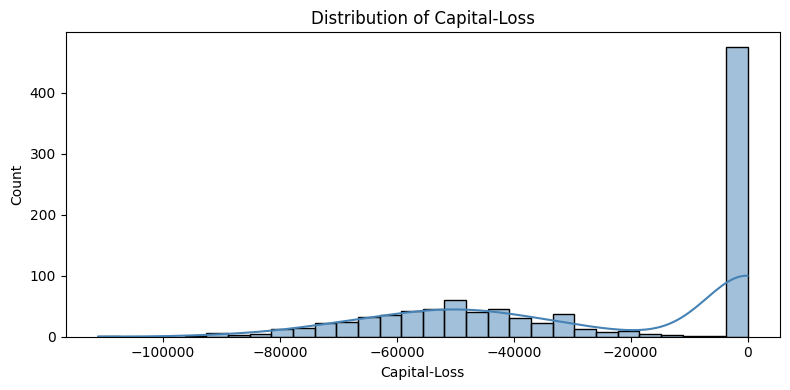

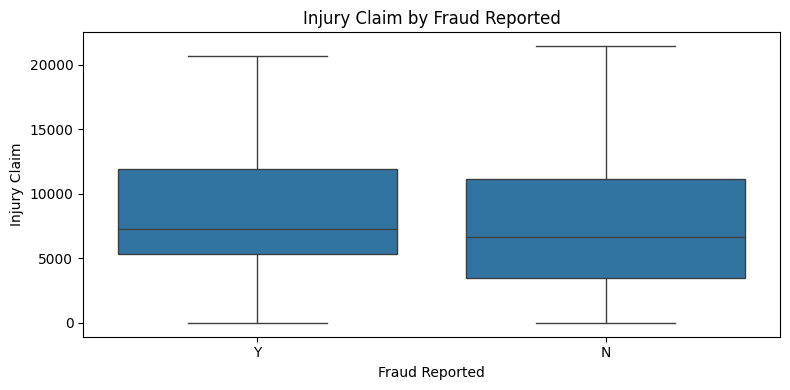

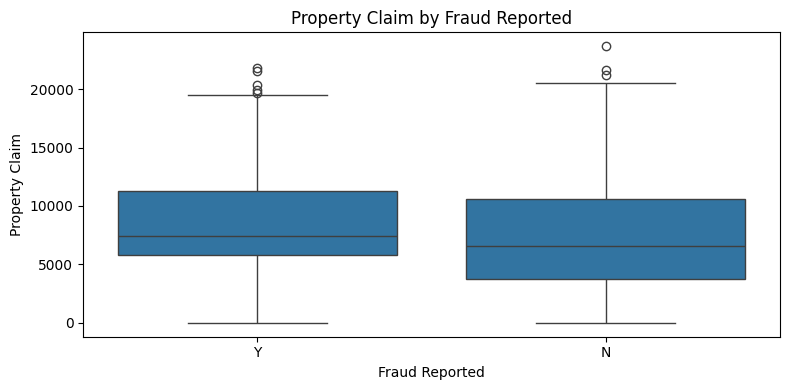

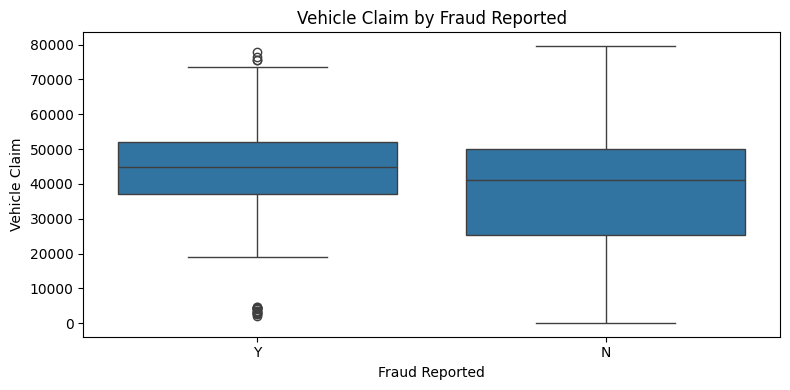

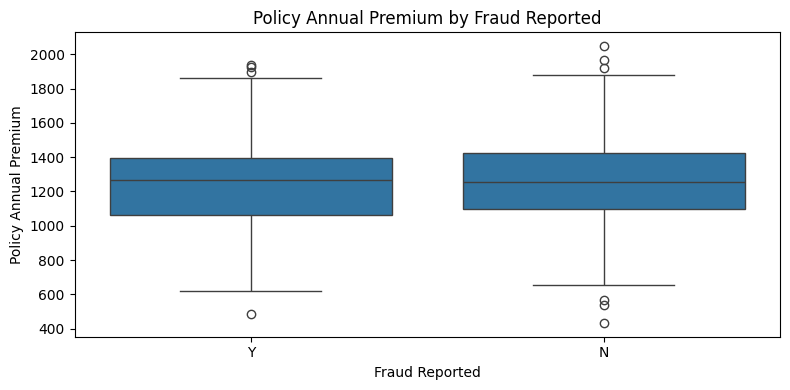

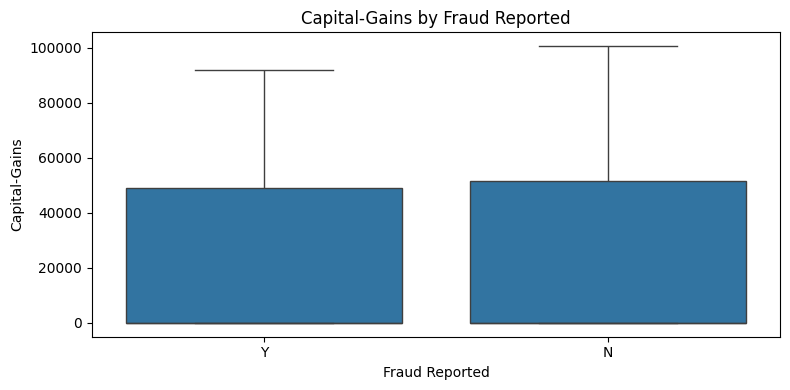

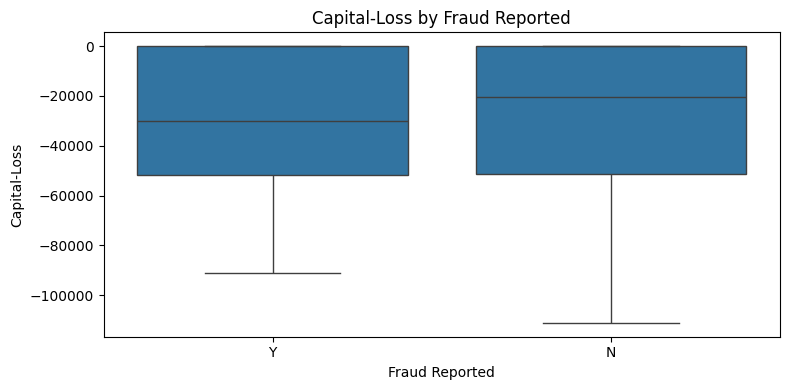

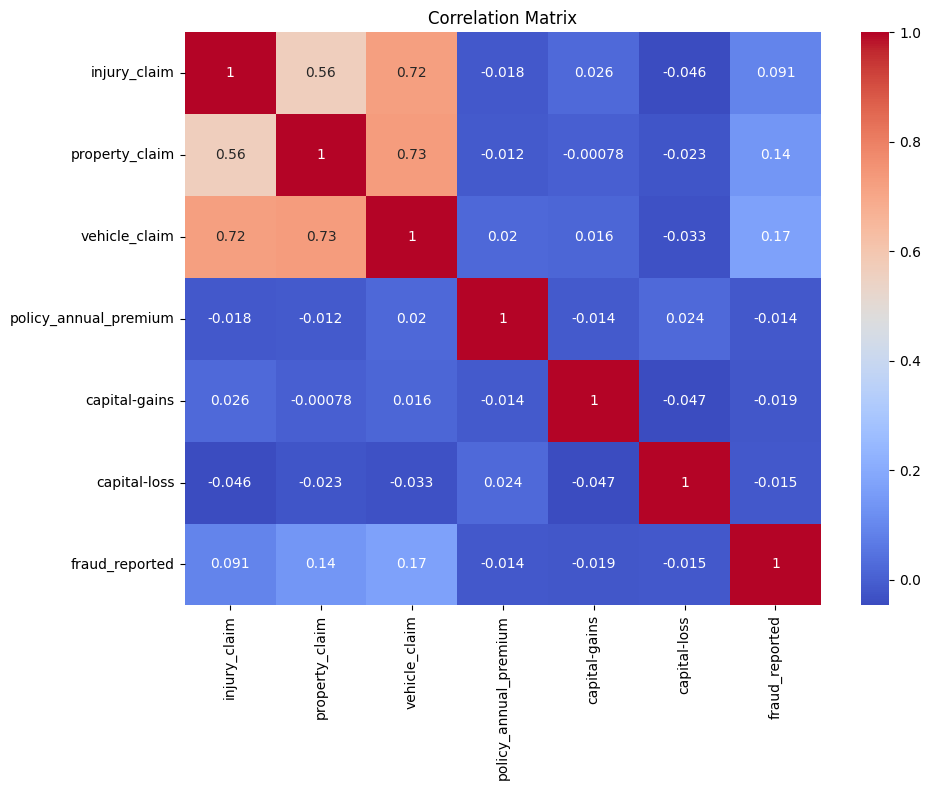

In [15]:
# 1. Target variable distribution (Fraud/Not Fraud)
plt.figure(figsize=(6,4))
df['fraud_reported'].value_counts().plot(kind='bar', color=['#4caf50', '#f44336'])
plt.title('Fraud Reported Distribution')
plt.xlabel('Fraud Reported')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=[category_mappings['fraud_reported'][i] for i in sorted(category_mappings['fraud_reported'])])
plt.show()

# 2. Fraud rate by categorical features
cat_features = ['incident_severity', 'incident_type', 'collision_type', 'insured_sex', 'policy_state', 'auto_make']
for col in cat_features:
    plt.figure(figsize=(8,4))
    # Map codes back to categories for labeling
    fraud_rate = df.groupby(col)['fraud_reported'].mean()
    sns.barplot(x=[category_mappings[col][i] for i in fraud_rate.index], y=fraud_rate.values, palette='viridis')
    plt.title(f'Fraud Rate by {col.replace("_", " ").title()}')
    plt.ylabel('Fraud Rate')
    plt.xlabel(col.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Numerical features: Claim amounts
num_features = ['injury_claim', 'property_claim', 'vehicle_claim', "policy_annual_premium", "capital-gains", "capital-loss"]
for col in num_features:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], bins=30, kde=True, color='steelblue')
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 4. Boxplot: Claim amounts by Fraud Reported
for col in num_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df['fraud_reported'].map(category_mappings['fraud_reported']), y=df[col])
    plt.title(f'{col.replace("_", " ").title()} by Fraud Reported')
    plt.xlabel('Fraud Reported')
    plt.ylabel(col.replace("_", " ").title())
    plt.tight_layout()
    plt.show()

# 5. Heatmap: Correlation matrix for numeric variables
plt.figure(figsize=(10,8))
sns.heatmap(df[num_features + ['fraud_reported']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [16]:
df.to_csv('cleaned_insurance_claims.csv', index=False)

import pickle

with open("categorical_mappings.pkl", "wb") as f:
    pickle.dump(category_mappings, f)
